<a href="https://colab.research.google.com/github/JGallegoPerez/israel_hamas_2023/blob/main/israel_hamas_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploration of Media Sentiment Pre and Post Israel-Hamas Escalation**

## In this report, we conduct a methodical examination of public sentiment as expressed in YouTube comments concerning the topic of "Israel", with a specific focus on the period preceding and following the events of the October 2023 Hamas-Israel conflict.

Our analysis is extensively facilitated by the use of  **Google Cloud Platform** services (therefore, it is also preferable if this notebook is run from Google Colab).

**OUTLINE:**

1. <u> Data Collection:</u>
Our initial phase involves the systematic extraction of YouTube comments using the term "Israel". This data collection spans two critical time frames: prior to and subsequent to October 7, 2023 (the day that Hamas initiated the attacks). For this purpose, we employ the **YouTube API**.

2. <u> Data Preprocessing and Feature Engineering:</u>
In the subsequent phase, we utilize the **Pandas** library to pre-process and transform the collected data. This process includes cleansing and the construction of relevant features to enhance the analytical value of the dataset. The refined data is then meticulously formatted into a **CSV** file, optimizing it for subsequent SQL queries (via Google Cloud **BigQuery**).

3. <u> Exploratory Analysis with SQL:</u>
With the data already in the right format, we transition to Google Cloud BigQuery for an in-depth exploratory analysis. The **SQL** language, facilitated by **BigQuery magic**, serves as our tool for mining insights from the dataset. The culmination of this stage is the synthesis of our findings into a dashboard utilizing **Looker Studio**. This tool not only integrates seamlessly with Google Cloud services but also streamlines the extraction of insights from BigQuery.

4. <u> Sentiment Analysis of Comments:</u>
To explore public sentiment in the comments, we utilize the Natural Language Toolkit (**NLTK**) library for sentiment analysis. This exploration includes both qualitative visualizations, such as **wordclouds**, and a quantitative sentiment assessment.

5. <u> Conclusion:</u> We find obvious differences in the public's attitudes towards the term "Israel" before and after the attack, with what appears to be a major sudden shift from positive to negative sentiment. We will discuss how to interpret the results.

**Disclaimer: we should approach the findings of this exploration with caution. It is critical to avoid hasty generalizations or the formulation of biases based on this singular dataset, the tools we employed and the interpretation we may make of the results.**

Let us begin by importing most the required libraries.

In [ ]:
from googleapiclient.discovery import build
import datetime
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


You must have a Google account and have your YouTube API credentials ready. Learn more at:
https://developers.google.com/youtube/v3

In [ ]:
# Use your YouTube API key
api_key = '<Your YouTube API key>'

In [ ]:
# Set up the YouTube Data API service
youtube = build('youtube', 'v3', developerKey=api_key)

# 1. DATA EXTRACTION

The following functions help us extract video related data from public YouTube videos.

In the end, we will obtain Pandas dataframes where each row represents a YouTube video and some data associated to it, including people's comments.

In [ ]:
def get_video_ids(response):
    """
    Returns all video id's from a search dictionary object. The API returns a maximum of 50 id's per search.
    We use this function inside other functions.
    """
    video_ids = []
    for item in response['items']:
        video_ids.append(item['id']['videoId'])
    print(f'{len(video_ids)} video ids' )

    return video_ids

In [ ]:
def all_info(youtube, video_ids):
    """
    Returns a Pandas dataframe from video id's.
    """
    all_comments = []
    all_video_info = []

    ## VIDEO INFO ##
    for i in range(0, len(video_ids), 50):
        request_videos = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response_videos = request_videos.execute()
        # There is a lot of information we can extract from the videos. We are interested only in the following:
        for video in response_videos['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'commentCount']                            }
            video_info = {}
            video_info['video_id'] = video['id']
            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None
            all_video_info.append(video_info)

    ## COMMENTS INFO ##
    for video_id in video_ids:
        try:
            request_comments = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id,
                maxResults=100,
                order="time"
            )
            response_comments = request_comments.execute()
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response_comments['items']]
            comments_in_video_info = {'comments': comments_in_video}
            all_comments.append(comments_in_video_info)
        except:
            # When error occurs, most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)

    video_info_df = pd.DataFrame(all_video_info)
    comments_info_df = pd.DataFrame(all_comments)
    videos_and_comments_df = pd.concat([video_info_df, comments_info_df], axis=1)

    return pd.DataFrame(videos_and_comments_df)

In [ ]:
# This function integrates the other two above.
# By default, YouTube API will give us only 50 search results per query.
# Then, to get more data, we conduct and stack the results of several queries (one per day).
def allinfo_df(yt_object, keyword, after_date, before_date):
    """
    Returns a response object based on keyword term, and starting and finishing timepoints for the search.
    It performs a new query per day, between the first and the last dates provided.
    """
    start_date = after_date
    end_date = before_date
    dates_list = []
    current_date = start_date
    next_date = current_date
    vids_and_comments_df = pd.DataFrame()
    while current_date < end_date:
        # Make list of intermediate dates in RFC 3339 format
        dates_list.append(current_date.strftime("%Y-%m-%dT%H:%M:%SZ"))
        next_date = current_date + timedelta(days=1)
        search_query = keyword
        request = yt_object.search().list(
            part="snippet",
            q=search_query,
            publishedAfter=current_date.strftime("%Y-%m-%dT%H:%M:%SZ"),
            publishedBefore=next_date.strftime("%Y-%m-%dT%H:%M:%SZ"),
            type='video',
            maxResults = 1000,
            relevanceLanguage="en"  ###
        )
        print("current_date: ", current_date)
        print("next_date: ", next_date)
        current_date += timedelta(days=1)
        response = request.execute()
        video_ids = get_video_ids(response)
        vids_and_comments_df = pd.concat([vids_and_comments_df, all_info(youtube, video_ids)])

    return vids_and_comments_df

We could focus on any major event that may cause a shift in public sentiment towards a specific term; so, we could easily reuse this notebook for other explorations.

In any case, here we are focusing on the Hamas-Israel escalation that began on the 7th of October, 2023. Thus, we are going to collect YouTube video data from before and after that specific date, encompassing the two weeks before and the two weeks after the event, correspondingly.

In [ ]:
# # Comment out if dataframe is directly loaded from CSV file
# Specify the beginnings and ends of the two periods we are interested in (before the event, and after the event)
startdate_before_event = date(2023, 9, 22)
enddate_before_event = date(2023, 10, 6)
startdate_after_event = date(2023, 10, 8)
enddate_after_event = date(2023, 10, 22)

# Collect the data and save them as Pandas dataframes. This might take some time.
before_event_df = allinfo_df(youtube, "Israel", startdate_before_event, enddate_before_event)
after_event_df = allinfo_df(youtube, "Israel", startdate_after_event, enddate_after_event)


current_date:  2023-09-22
next_date:  2023-09-23
50 video ids


Could not get comments for video kNH85jgzJ0Y


Could not get comments for video CnGEDzaDcZI
current_date:  2023-09-23
next_date:  2023-09-24
50 video ids


Could not get comments for video gbhi4z5jloQ
Could not get comments for video Cj7H0w7q8ZU
current_date:  2023-09-24
next_date:  2023-09-25
50 video ids


Could not get comments for video 0qkhsC5C9x4


Could not get comments for video WUSirGxWh-U
current_date:  2023-09-25
next_date:  2023-09-26
50 video ids


Could not get comments for video cxH9ItshHSI


Could not get comments for video FIHPEAKNp-A
current_date:  2023-09-26
next_date:  2023-09-27
50 video ids


Could not get comments for video WDuRQ3pFbh4
current_date:  2023-09-27
next_date:  2023-09-28
50 video ids
current_date:  2023-09-28
next_date:  2023-09-29
50 video ids
current_date:  2023-09-29
next_date:  2023-09-30
50 video ids
current_date:  2023-09-30
next_date:  2023-10-01
50 video ids


Could not get comments for video nd__Rp780zo


Could not get comments for video QIGUhlmkRZI


Could not get comments for video ho_N8qlW5xY
current_date:  2023-10-01
next_date:  2023-10-02
50 video ids


Could not get comments for video 6OYB2I0ORNA
Could not get comments for video aIe8lt4QoUI
Could not get comments for video akk8sM9KV2g


Could not get comments for video 8v_ToU_pfL0


Could not get comments for video cb12KmMMDJA
Could not get comments for video OyQKThz41wg
current_date:  2023-10-02
next_date:  2023-10-03
50 video ids


Could not get comments for video kfgHPj3E9QQ


Could not get comments for video 1E-z28HdbzM
current_date:  2023-10-03
next_date:  2023-10-04
50 video ids


Could not get comments for video j_LlMCNgjqA


Could not get comments for video YwwOGYgEIpQ
current_date:  2023-10-04
next_date:  2023-10-05
50 video ids


Could not get comments for video fUkmqzrcuW4


Could not get comments for video 1BTsX2WBg8Q
current_date:  2023-10-05
next_date:  2023-10-06
50 video ids


Could not get comments for video xUMn6uq8a70


Could not get comments for video 9iWRUQufGbc


Could not get comments for video we6AEoX2mj8
Could not get comments for video YDxnQEqP9f8


Could not get comments for video iXs5cpg3TwQ


Could not get comments for video 1e7ncomHgoA
current_date:  2023-10-08
next_date:  2023-10-09
50 video ids


Could not get comments for video jVRO2Q1LCcc


Could not get comments for video 9AJLac4iDFg
Could not get comments for video -5GUjb_3V5A
Could not get comments for video it_nHNPEfd8
Could not get comments for video gKjFcCydeGs


Could not get comments for video 6zRp0VaaMDA


Could not get comments for video cZ83Q7tM4A0
current_date:  2023-10-09
next_date:  2023-10-10
50 video ids


Could not get comments for video zsNj8DiJv-A


Could not get comments for video f2fvHp2tbzE


Could not get comments for video NybU9LlDf8g


Could not get comments for video vK79VDAc2hw
Could not get comments for video OOKkDcwzlAE


Could not get comments for video Uw-MEeRvBNg


Could not get comments for video uFYc1PeOFCA


Could not get comments for video B3_yQ4mgOks
Could not get comments for video b-rMTOjOTRE
current_date:  2023-10-10
next_date:  2023-10-11
50 video ids


Could not get comments for video 4yXR_Q_sScY


Could not get comments for video tPfQe6MtzDE


Could not get comments for video 0nWgOWWYkQI


Could not get comments for video rDdAWRWRiMs
current_date:  2023-10-11
next_date:  2023-10-12
50 video ids


Could not get comments for video LVsvU6cqzRo


Could not get comments for video 9oCOCvLTQNI


Could not get comments for video ZDHyGrbWXZU


Could not get comments for video K_U8PFXaFVU


Could not get comments for video NPoyd9l3lJI


Could not get comments for video 8fiuudd432Y


Could not get comments for video 4hYkgGMpe2g


Could not get comments for video diV4hF930Eg
Could not get comments for video aaBqNG8fkWo
current_date:  2023-10-12
next_date:  2023-10-13
50 video ids


Could not get comments for video Ar_9UCZaJHw


Could not get comments for video bW8gY_5Kzcw


Could not get comments for video vHaHzr5M7gk


Could not get comments for video qenkS-YMubI
current_date:  2023-10-13
next_date:  2023-10-14
50 video ids


Could not get comments for video VAh1cKtEc8M


Could not get comments for video qFb2XCnQMB4


Could not get comments for video QMbQ1aZ7PRg


Could not get comments for video LFGmGPVtFNc


Could not get comments for video ny51G4XUfp8


Could not get comments for video Ydq9-Da9ilI
current_date:  2023-10-14
next_date:  2023-10-15
50 video ids


Could not get comments for video NeFuOIUM1qc


Could not get comments for video yID-vH2RLRQ


Could not get comments for video 9apcmWZOGFc


Could not get comments for video vX6HSBwfIO8


Could not get comments for video kecYngYSy04
current_date:  2023-10-15
next_date:  2023-10-16
50 video ids


Could not get comments for video bEF8fxGnTtc


Could not get comments for video fzWJGxGZ2FI
current_date:  2023-10-16
next_date:  2023-10-17
50 video ids


Could not get comments for video GkNYB0DayKo


Could not get comments for video AlxjtVcN5mQ


Could not get comments for video 7IE9eDvG_Tw
Could not get comments for video MtbvY1j82gc
current_date:  2023-10-17
next_date:  2023-10-18
50 video ids


Could not get comments for video QVw-uymnaYk


Could not get comments for video uKupoNutUSA


Could not get comments for video vJvhg4Gxk6E


Could not get comments for video GG7ss3jYKYk


Could not get comments for video EVff6mq9-pg


Could not get comments for video JMcI1ZiQfWQ
Could not get comments for video vBpNUVC0dSU


Could not get comments for video BusNb2jt1NU
current_date:  2023-10-18
next_date:  2023-10-19
50 video ids


Could not get comments for video ESzCGAMgTcg


Could not get comments for video CeddkAb8Ub0


Could not get comments for video 6ZZg2_yzMII


Could not get comments for video kDXSZKkgk4E


Could not get comments for video U4zX8RbEkIU
current_date:  2023-10-19
next_date:  2023-10-20
50 video ids


Could not get comments for video Bug_O699_yQ


Could not get comments for video jeNpmUb4Lak


Could not get comments for video ocEKcEqDQww
current_date:  2023-10-20
next_date:  2023-10-21
50 video ids


Could not get comments for video OYJFHtTYc0g


Could not get comments for video 6Jpoy6L-VKU


Could not get comments for video kGlMutroZBA


Could not get comments for video hH_Kcj5Ikqs


Could not get comments for video 5pkapvWfTsw


Could not get comments for video PqR1IFz5da8


Could not get comments for video 9kCdnhAMtM0


Could not get comments for video RcpzXWJYsxY
current_date:  2023-10-21
next_date:  2023-10-22
50 video ids


Could not get comments for video eeQDv8QlHZk


Could not get comments for video 9Fg2iDKl04o


Could not get comments for video NAvVIXVwK1w


# 2. PREPROCESSING & FEATURE ENGINEERING

Let us take a quick look at the data we just extracted, starting with the data before the event.

In [ ]:
before_event_df.describe()

,video_id,channelTitle,title,description,publishedAt,viewCount,likeCount,commentCount,comments
count,700,700,700,700,700,700,662,688,670
unique,700,490,681,434,700,622,355,226,480
top,IJUXKq2bgQ8,Dilyara Shorts,ISRAEL - HOLY LAND - CATHOLIC PILGRIMAGES - GL...,,2023-09-22T19:01:51Z,0,2,0,[]
freq,1,18,10,244,1,6,36,208,191


In [ ]:
before_event_df.head()

,video_id,channelTitle,title,description,publishedAt,viewCount,likeCount,commentCount,comments
0,IJUXKq2bgQ8,Al Jazeera English,"Netanyahu touts peace with Saudi Arabia, issue...",Israeli Prime Minister Benjamin Netanyahu has ...,2023-09-22T19:01:51Z,682767,2204,2828,[Great presentation skills. He just divided th...
1,kNH85jgzJ0Y,PBS NewsHour,WATCH: Israeli Prime Minister Benjamin Netanya...,Stream your PBS favorites with the PBS app: ht...,2023-09-22T13:45:38Z,253402,2916,None,"[This Mega Corridor look like a Coy, now Why N..."
2,ZYTehyVodwo,Associated Press,Benjamin Netanyahu tells UN that Israel is 'at...,Israeli Prime Minister Benjamin Netanyahu says...,2023-09-22T14:55:18Z,29417,252,150,[]
3,7xgclIzo0qo,The Bayit,Rav Avi Message from outside the Israel Missio...,,2023-09-22T13:41:45Z,191,11,0,"[This did not age well, Well, scrap that., ❤️❤..."
4,OeGxTuck5ms,CBN News,Israeli-Saudi Relations on the Horizon | Jerus...,Netanyahu highlights threats facing Israel and...,2023-09-22T22:00:25Z,55961,1086,292,[One person's hero is another ones terrorist...


In [ ]:
before_event_df.isna().sum()

video_id         0
channelTitle     0
title            0
description      0
publishedAt      0
viewCount        0
likeCount       38
commentCount    12
comments        30
dtype: int64

Everything seems OK thus far. We have some null entries in likeCount, commentCount and comments. Also, we receive the comments as nested lists, which we will need to address later. Now, the data after the event:

In [ ]:
after_event_df.describe()

,video_id,channelTitle,title,description,publishedAt,viewCount,likeCount,commentCount,comments
count,700,700,700,700,700,700,699,625,623
unique,700,151,696,693,699,700,677,567,617
top,FXrVtabZggI,Sky News,"Israel warns citizens to leave Egypt, Jordan a...",,2023-10-18T12:09:22Z,5165203,653,0,[]
freq,1,43,2,4,2,1,3,8,7


In [ ]:
after_event_df.head()

,video_id,channelTitle,title,description,publishedAt,viewCount,likeCount,commentCount,comments
0,FXrVtabZggI,BBC News,700 dead in Israel as it “declares war” on Ham...,Israeli has formally declared war on the Hamas...,2023-10-08T22:46:23Z,5165203,46293,23295,"[Israel = Apartheid, Hamas = terrorists!. Pala..."
1,jVRO2Q1LCcc,DW News,Is Israel planning a ground incursion into Gaz...,Israel has declared a state of war after a mas...,2023-10-08T15:10:42Z,1436150,11901,None,[I'll be posting updates the Israeli Palestini...
2,OXiW6hhC6Bs,Task & Purpose,Israel is at War,I'll be posting updates here: https://www.inst...,2023-10-08T02:07:43Z,7068331,144959,22880,"[Wtf?!!where are israel attact palestine?, 🤣🤣🤣..."
3,_45HVw5pEA8,Sky News,Israel-Hamas war: Many killed in Sderot follow...,The Israeli city of Sderot is waking up to the...,2023-10-08T21:36:52Z,1131062,7683,3463,[Anti zionism is antisemitism as over half the...
4,F6_p78k43NY,MSNBC,Palestinian Americans in Chicago's 'Little Pal...,"NBC News' Maggie Vespa reports from the ""Littl...",2023-10-08T20:00:02Z,242832,1242,2084,[BILLIONS OF TAXPEYES MONEY IN WARS KILLINGS S...


In [ ]:
after_event_df.isna().sum()

video_id         0
channelTitle     0
title            0
description      0
publishedAt      0
viewCount        0
likeCount        1
commentCount    75
comments        77
dtype: int64

Same kind of dataset as one before the event.

For the sake of simplicity, we are going to merge the two datasets into one. We will also create a new column referring to whether the data entry is from before or after the event.

In [ ]:
before_event_df.insert(0, "from_event", 'before')
after_event_df.insert(0, "from_event", 'after')

In [ ]:
israel_attack_df = pd.concat([before_event_df, after_event_df])

In [ ]:
# Check the first rows of the new dataframe
israel_attack_df.head()

,from_event,video_id,channelTitle,title,description,publishedAt,viewCount,likeCount,commentCount,comments
0,before,IJUXKq2bgQ8,Al Jazeera English,"Netanyahu touts peace with Saudi Arabia, issue...",Israeli Prime Minister Benjamin Netanyahu has ...,2023-09-22T19:01:51Z,682767,2204,2828,[Great presentation skills. He just divided th...
1,before,kNH85jgzJ0Y,PBS NewsHour,WATCH: Israeli Prime Minister Benjamin Netanya...,Stream your PBS favorites with the PBS app: ht...,2023-09-22T13:45:38Z,253402,2916,None,"[This Mega Corridor look like a Coy, now Why N..."
2,before,ZYTehyVodwo,Associated Press,Benjamin Netanyahu tells UN that Israel is 'at...,Israeli Prime Minister Benjamin Netanyahu says...,2023-09-22T14:55:18Z,29417,252,150,[]
3,before,7xgclIzo0qo,The Bayit,Rav Avi Message from outside the Israel Missio...,,2023-09-22T13:41:45Z,191,11,0,"[This did not age well, Well, scrap that., ❤️❤..."
4,before,OeGxTuck5ms,CBN News,Israeli-Saudi Relations on the Horizon | Jerus...,Netanyahu highlights threats facing Israel and...,2023-09-22T22:00:25Z,55961,1086,292,[One person's hero is another ones terrorist...


In [ ]:
# Check the last rows
israel_attack_df.tail()

,from_event,video_id,channelTitle,title,description,publishedAt,viewCount,likeCount,commentCount,comments
45,after,lCMT-T2Y7OY,WION,"Hezbollah says it launched missiles at Israel,...",Israel warned civilians to stay out of the Leb...,2023-10-21T06:27:33Z,134721,731,199,"[Thank you, Tell Hamas to quit hiding under ho..."
46,after,ExmMG2Ttnws,Pastor Mark Driscoll,A History of Hamas & Israel,A history of Hamas & Israel.\n\nThis is a clip...,2023-10-21T16:24:33Z,12403,549,80,"[Nuke em all, Que estas protestas no sean en v..."
47,after,wIWs1h-Zqf8,Firstpost,"LIVE: Biden's Israel Visit, Hamas' Hypocrisy, ...","LIVE: Biden's Israel Visit, Hamas' Hypocrisy, ...",2023-10-21T16:18:24Z,637343,8326,1683,NaN
48,after,32Qp8hVg9X0,TRT World,Israel's narrative of Al Ahli Arab Hospital at...,"In this in-depth video, we delve into the Al A...",2023-10-21T07:04:06Z,51729,3406,478,NaN
49,after,-YuYeQ0CnpU,Middle East Eye,"Over 300,000 gather in central London to prote...","In a massive show of solidarity, over 300,000 ...",2023-10-21T16:42:34Z,610181,49752,3680,NaN


Check the data types and adress the empty entries.

In [ ]:
israel_attack_df.dtypes

from_event      object
video_id        object
channelTitle    object
title           object
description     object
publishedAt     object
viewCount       object
likeCount       object
commentCount    object
comments        object
dtype: object

In [ ]:
# Change the types of columns 'likeCount' and 'commentCount' to int. Before that, "None" values are replaced with 0.
israel_attack_df['likeCount'] = israel_attack_df['likeCount'].fillna(0).astype(int)
israel_attack_df['commentCount'] = israel_attack_df['commentCount'].fillna(0).astype(int)

In [ ]:
# Replace empty entries with mean values, except for the 'comments' column
israel_attack_df['likeCount'].fillna(israel_attack_df['likeCount'].mean(), inplace=True)
israel_attack_df['commentCount'].fillna(israel_attack_df['commentCount'].mean(), inplace=True)

Transform comments from nested lists to strings. This will be convenient to store the data as CSV files and for the later processing.

In [ ]:
def nested_list_to_string(lst):
    result = []
    if not isinstance(lst, list):
        lst = ["Nan"]
    for item in lst:
        if isinstance(item, list):
            result.append(nested_list_to_string(item))
        elif not isinstance(item, float):
            result.append(item)
    return " #@# ".join(result) # " #@# " is used as an arbitrary separator between comments

In [ ]:
israel_attack_df['comments'] = israel_attack_df['comments'].apply(nested_list_to_string)

In [ ]:
# Show a random sample of comments to see if they look alright
israel_attack_df['comments'].sample(10)

9     Harari is dangerous and part of this  terrible...
22    The woman talks like she knows everything exce...
16    Hamas je pun...awk pakai jet pakai meriam pn t...
25    Give Palestine back to the Palestinians!!!!!!!...
30    🕷spider vs fly #@# 😂😂😂😂😂🎉 #@# If wasn't for re...
0     This is the kind of of people Christian world ...
45    Israel nhi Palestine. #@# Israel nahi, occupie...
41    The world police strikes again, meanwhile our ...
47                                في فلسطين #@# وين هذا
4     Please like and share with your friends so mor...
Name: comments, dtype: object

So far, we have our date entries in RFC 3339 format, which is what the YouTube API returns. It looks like this:

In [ ]:
israel_attack_df['publishedAt'].head(2)

0    2023-09-22T19:01:51Z
1    2023-09-22T13:45:38Z
Name: publishedAt, dtype: object

We will transform the date data format to ISO 8601 standard (YYYY-MM-DD), which will be more convenient and is widely used in SQL databases.

In [ ]:
def rfc3339_to_iso8601(date_str):
    return date_str.split('T')[0]

In [ ]:
israel_attack_df['publishedAt'] = israel_attack_df['publishedAt'].apply(rfc3339_to_iso8601)

Save the dataset as a CSV file.

In [ ]:
# Save the dataset as a CSV file, which might be convenient to save time when exploring the data.
israel_attack_df.to_csv('israel_attack.csv')

# 3. EXPLORATORY ANALYSIS (SQL-queried, excluding analysis of comments)

We will carry out this first part of the exploratory analysis using Google Cloud BigQuery and SQL queries. **We are doing it this way for demonstrations purposes**; we could reach the same goals if we just continued with Pandas.

In [ ]:
# Create a new dataframe to upload to BigQuery, dropping several columns that are not needed for now
israel_bq = israel_attack_df.drop(columns=['comments', 'description'])

Connecting to BigQuery. You must at least have a project already set up; we will add a dataset and table to it.

In [ ]:
# Running this, we are asked for permission to access our Google credentials
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project='<your project ID>') # Enter your project ID

Create a dataset in BigQuery called "event_analysis".

In [ ]:
dataset_id = 'event_analysis'
dataset_ref = client.dataset(dataset_id)
dataset = bigquery.Dataset(dataset_ref)
dataset.location = 'asia-east1' # The location should ideally be the closest to you. Check the BigQuery documentation
dataset = client.create_dataset(dataset)

Create and fill a table inside our dataset, based on the dataset from the Pandas DataFrame that we prepared.

In [ ]:
table_id = "<your project ID>.event_analysis.israel_attack" # Enter your project ID at the beginning of the string
job_config = bigquery.LoadJobConfig(
    schema=[
    ],
    write_disposition="WRITE_TRUNCATE",
)
job = client.load_table_from_dataframe(
    israel_bq, table_id, job_config=job_config
)
job.result()  # Wait for the job to complete.

Let us run a simple SQL command with BigQuery magic, just to see if it works.
Enter your own project ID always with the BigQuery magic commands.

In [ ]:
%%bigquery --project <your project ID>
SELECT * FROM `<your project ID>.event_analysis.israel_attack`
WHERE viewCount > 800000
LIMIT 5;

Executing query with job ID: b8d2e2c2-31f6-4435-942a-5fda66ac10e3
Query executing: 1.02s


ERROR:
 400 No matching signature for operator > for argument types: STRING, INT64. Supported signature: ANY > ANY at [2:7]

Location: asia-east1
Job ID: b8d2e2c2-31f6-4435-942a-5fda66ac10e3



"Oops, it seems we had forgotten to change the data type of viewCount to Integer". No problem, we will fix it with SQL. But first, let us check the data types of all columns to make sure we don't make more mistakes.

In [ ]:
%%bigquery --project <your project ID>
SELECT
    column_name,
    data_type
FROM
    `event_analysis`.INFORMATION_SCHEMA.COLUMNS
WHERE
    table_name = 'israel_attack';

Query is running:   0%|          |

Downloading:   0%|          |

,column_name,data_type
0,from_event,STRING
1,video_id,STRING
2,channelTitle,STRING
3,title,STRING
4,publishedAt,DATE
5,viewCount,INT64
6,likeCount,INT64
7,commentCount,INT64


Not only should viewCount be Integer, but also publishedAt should be of Date type.

In [ ]:
%%bigquery --project <your project ID>
CREATE OR REPLACE TABLE `event_analysis.israel_attack` AS
SELECT
    from_event,
    video_id,
    channelTitle,
    title,
    CAST(publishedAt AS DATE) as publishedAt,
    CAST(viewCount AS INT64) as viewCount,
    likeCount,
    commentCount
FROM
    `event_analysis.israel_attack`;

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project <your project ID>
SELECT
    column_name,
    data_type
FROM
    `event_analysis`.INFORMATION_SCHEMA.COLUMNS
WHERE
    table_name = 'israel_attack';

Query is running:   0%|          |

Downloading:   0%|          |

,column_name,data_type
0,from_event,STRING
1,video_id,STRING
2,channelTitle,STRING
3,title,STRING
4,publishedAt,DATE
5,viewCount,INT64
6,likeCount,INT64
7,commentCount,INT64


Now the data types are alright. Let us start the exploratory analysis as such.

## Basic counts before and after the event

In [ ]:
%%bigquery --project <your project ID>
SELECT
    from_event,
    COUNT(*) as video_count
FROM
    `event_analysis.israel_attack`
GROUP BY
    from_event;

Query is running:   0%|          |

Downloading:   0%|          |

,from_event,video_count
0,before,700
1,after,700


(We know this already from the Pandas DataFrames).

## Public interest in the topic before and after the event

We can look at the counts of video views, likes and comments to get an impression of how interested people were in "Israel" before and after the terrorist attack.

In [ ]:
%%bigquery --project <your project ID>
SELECT
    from_event,
    SUM(viewCount) as total_views,
    SUM(likeCount) as total_likes,
    SUM(commentCount) as total_comments
FROM
    `event_analysis.israel_attack`
GROUP BY
    from_event;

Query is running:   0%|          |

Downloading:   0%|          |

,from_event,total_views,total_likes,total_comments
0,before,168854688,2570991,252176
1,after,568771042,7898677,2196651


We see how the three measures reach far greater levels after the event compared to before, which we might have expected.

It might be more correct to show the averages per video:  

In [ ]:
%%bigquery --project <your project ID>
SELECT
    from_event,
    AVG(viewCount) as avg_views_per_video,
    AVG(likeCount) as avg_likes_per_video,
    AVG(commentCount) as avg_comments_per_video
FROM
    `event_analysis.israel_attack`
GROUP BY
    from_event;

Query is running:   0%|          |

Downloading:   0%|          |

,from_event,avg_views_per_video,avg_likes_per_video,avg_comments_per_video
0,before,241220.982857,3672.844286,360.251429
1,after,812530.060000,11283.824286,3138.072857


## Channel coverage on the topic

What channels referred to the term "Israel" most often? It seems likely that this changed with the attack.

**Before the attack:**

In [ ]:
%%bigquery --project <your project ID>
SELECT
    from_event,
    channelTitle as channel,
    COUNT(*) as video_count,
    SUM(viewCount) as total_views
FROM
    `event_analysis.israel_attack`
WHERE
    from_event='before'
GROUP BY
    from_event, channelTitle
ORDER BY
    total_views DESC
LIMIT 10;

Query is running:   0%|          |

Downloading:   0%|          |

,from_event,channel,video_count,total_views
0,before,Todo Noticias,1,35820550
1,before,UFC,2,18763163
2,before,Middle East Eye,3,14156289
3,before,ESPN MMA,1,9271760
4,before,Visit Israel,2,9240857
5,before,Sky News,2,6737734
6,before,Israel & Rodolffo,1,5777482
7,before,News18 India,8,4875411
8,before,KOMPASTV,1,3937770
9,before,War Stories,1,3684174


**After the attack:**

In [ ]:
%%bigquery --project <your project ID>
SELECT
    from_event,
    channelTitle as channel,
    COUNT(*) as video_count,
    SUM(viewCount) as total_views
FROM
    `event_analysis.israel_attack`
WHERE
    from_event='after'
GROUP BY
    from_event, channelTitle
ORDER BY
    total_views DESC
LIMIT 10;

Query is running:   0%|          |

Downloading:   0%|          |

,from_event,channel,video_count,total_views
0,after,BBC News,29,47015044
1,after,The Telegraph,9,41522046
2,after,Piers Morgan Uncensored,4,38669084
3,after,Channel 4 News,13,36901712
4,after,NBC News,40,29541906
5,after,Sky News,49,21271962
6,after,Firstpost,11,18176847
7,after,Hindustan Times,17,18088277
8,after,CNN,32,17692771
9,after,WION,24,12157531


We can compare the most popular channels, in terms of total video views, before and after the attack.

Interestingly, the popular channels before the attack appear to be a heterogeneous mix in terms of the countries of the channels and the contents (e.g., we see channels from India and Spain, and another channel about tourism). However, after the attack, as we might expect, the most popular channels focus on news and are mainstream news channels (e.g. BBC News and The Telegraph).

## Temporal trend of video views
Immediately after the attack, the public may have shown the greatest interest (which we will measure as the number of views per day). This interest may have declined over time since the first attacks.

In [ ]:
%%bigquery --project <your project ID>
SELECT
    publishedAt,
    SUM(viewCount) as total_views
FROM
    `event_analysis.israel_attack`
WHERE
    from_event = 'after'
GROUP BY
    publishedAt
ORDER BY
    publishedAt;

Query is running:   0%|          |

Downloading:   0%|          |

,publishedAt,total_views
0,2023-10-08,100861864
1,2023-10-09,72605852
2,2023-10-10,56031383
3,2023-10-11,50424924
4,2023-10-12,50487255
5,2023-10-13,29374210
6,2023-10-14,38214303
7,2023-10-15,26788806
8,2023-10-16,35471887
9,2023-10-17,39961874


We find some evidence that supports our assumption: in the days that followed the attack, there appears to be a descending trend in the interest regarding the term "Israel".





## Looker Studio dashboard

Using Google's BigQuery, it is quite straightforward to create a dashboard in Looker Studio. With the results from the previous SQL queries we can create the following dashboard, which offers a more intuitive look on the data we analyzed so far:

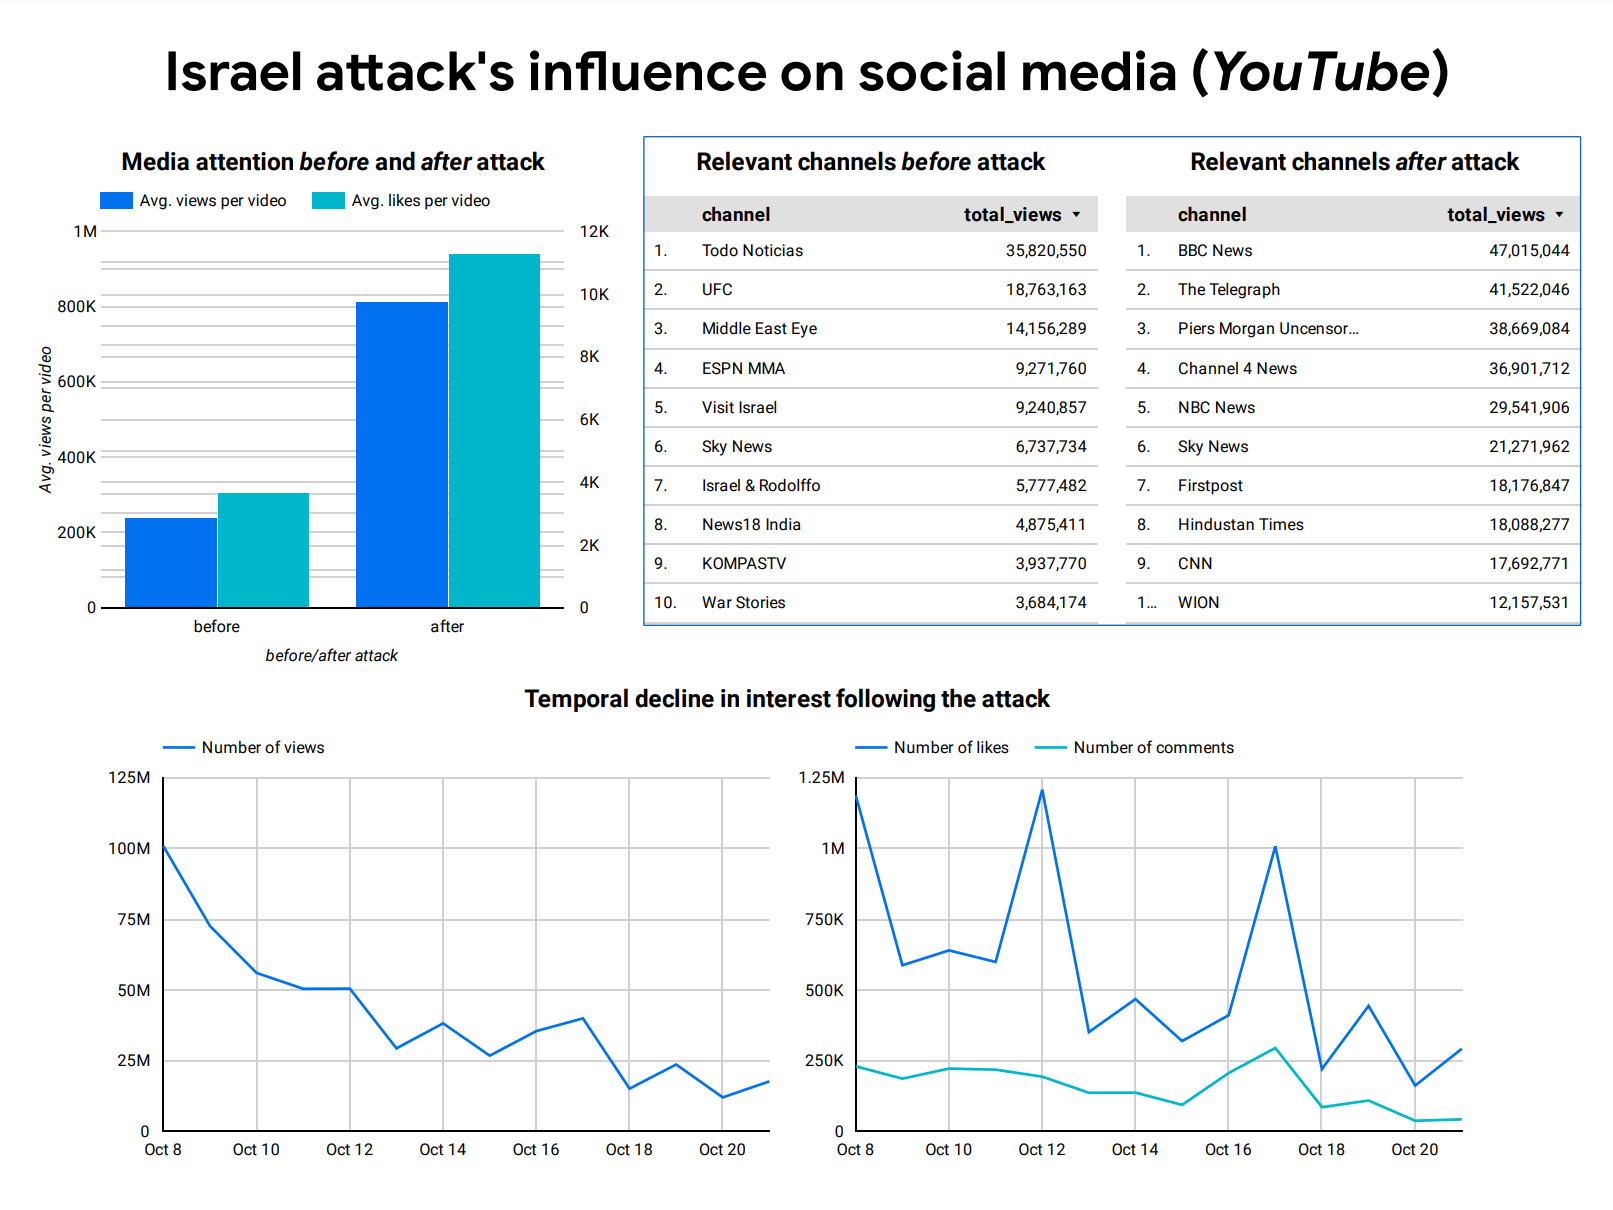

# 4. EXPLORATORY ANALYSIS (analysis of comments)

Here, we will explore the content of the comments, which will allow us to glance into people's sentiment more directly.

We are going to create wordclouds to visualize the most common words from the comments; later, we will measure the public's sentiment quantitatively.

In [ ]:
# # Uncomment this cell if you saved the CSV file in Google Colab and you lost contact with the dataframe due to disconnection
# israel_attack_df = pd.read_csv('/content/israel_attack.csv')

In [ ]:
# We create a set of stopwords (words that are not relevant in terms of emotional value) to be removed from the comments
# Even though YouTube API searched for videos that are supposed to relate mostly to English, there are still some foreign words that "leaked through"
stop_words = set(stopwords.words('english'))
more_stopwords = {"israel", "israeli", "el", "se", "de", "del", "la", "las", "que", "en", "di", "su", "con", "ya", "su", "video", "não",
                  "por", "para", "one", "un", "una", "si", "u", "tu", "è", "che", "ja", "pero", "https", "also", "et", "al", "da", "é",
                  "e", "lo", "ko", "ka", "os", "ye", "ki", "I'm", "em", "ni", "te", "como", "get","got", "le", "es", "let", "still", "yet",
                  "los", "dont"}
stop_words.update(more_stopwords)

In [ ]:
# The column 'comments' from the dataframe event_df contains comments separated by the string " #@# ".
# This function returns a list of all the words from the comments in the dataframe.
# It also removes the stopwords and punctuation.
def comments_to_words(df):
    comments = df['comments'].str.cat(sep=' #@# ')
    tokens = word_tokenize(comments)
    # Convert to lowercase
    tokens = [w.lower() for w in tokens]
    # Remove punctuation
    import string
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # Remove non-alphabetic tokens
    words = [word for word in stripped if word.isalpha()]
    # Remove stopwords
    words = [w for w in words if not w in stop_words]
    return words

In [ ]:
# Apply the function comments_to_words to the dataframe israel_attack_df, but only to the comments before the event
words_before = comments_to_words(israel_attack_df[israel_attack_df['from_event'] == 'before'])
# Same, but only to the comments after the event
words_after = comments_to_words(israel_attack_df[israel_attack_df['from_event'] == 'after'])

In [ ]:
# Function that removes stopwords from a list of words
def remove_stopwords(word_list):
    return [w for w in word_list if not w in stop_words]

In [ ]:
words_before_filtered = remove_stopwords(words_before)
words_after_filtered = remove_stopwords(words_after)

## Wordclouds

Let us begin with a wordcloud that corresponds to the YouTube comments before the attack.

In [ ]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud)
    plt.axis("off")

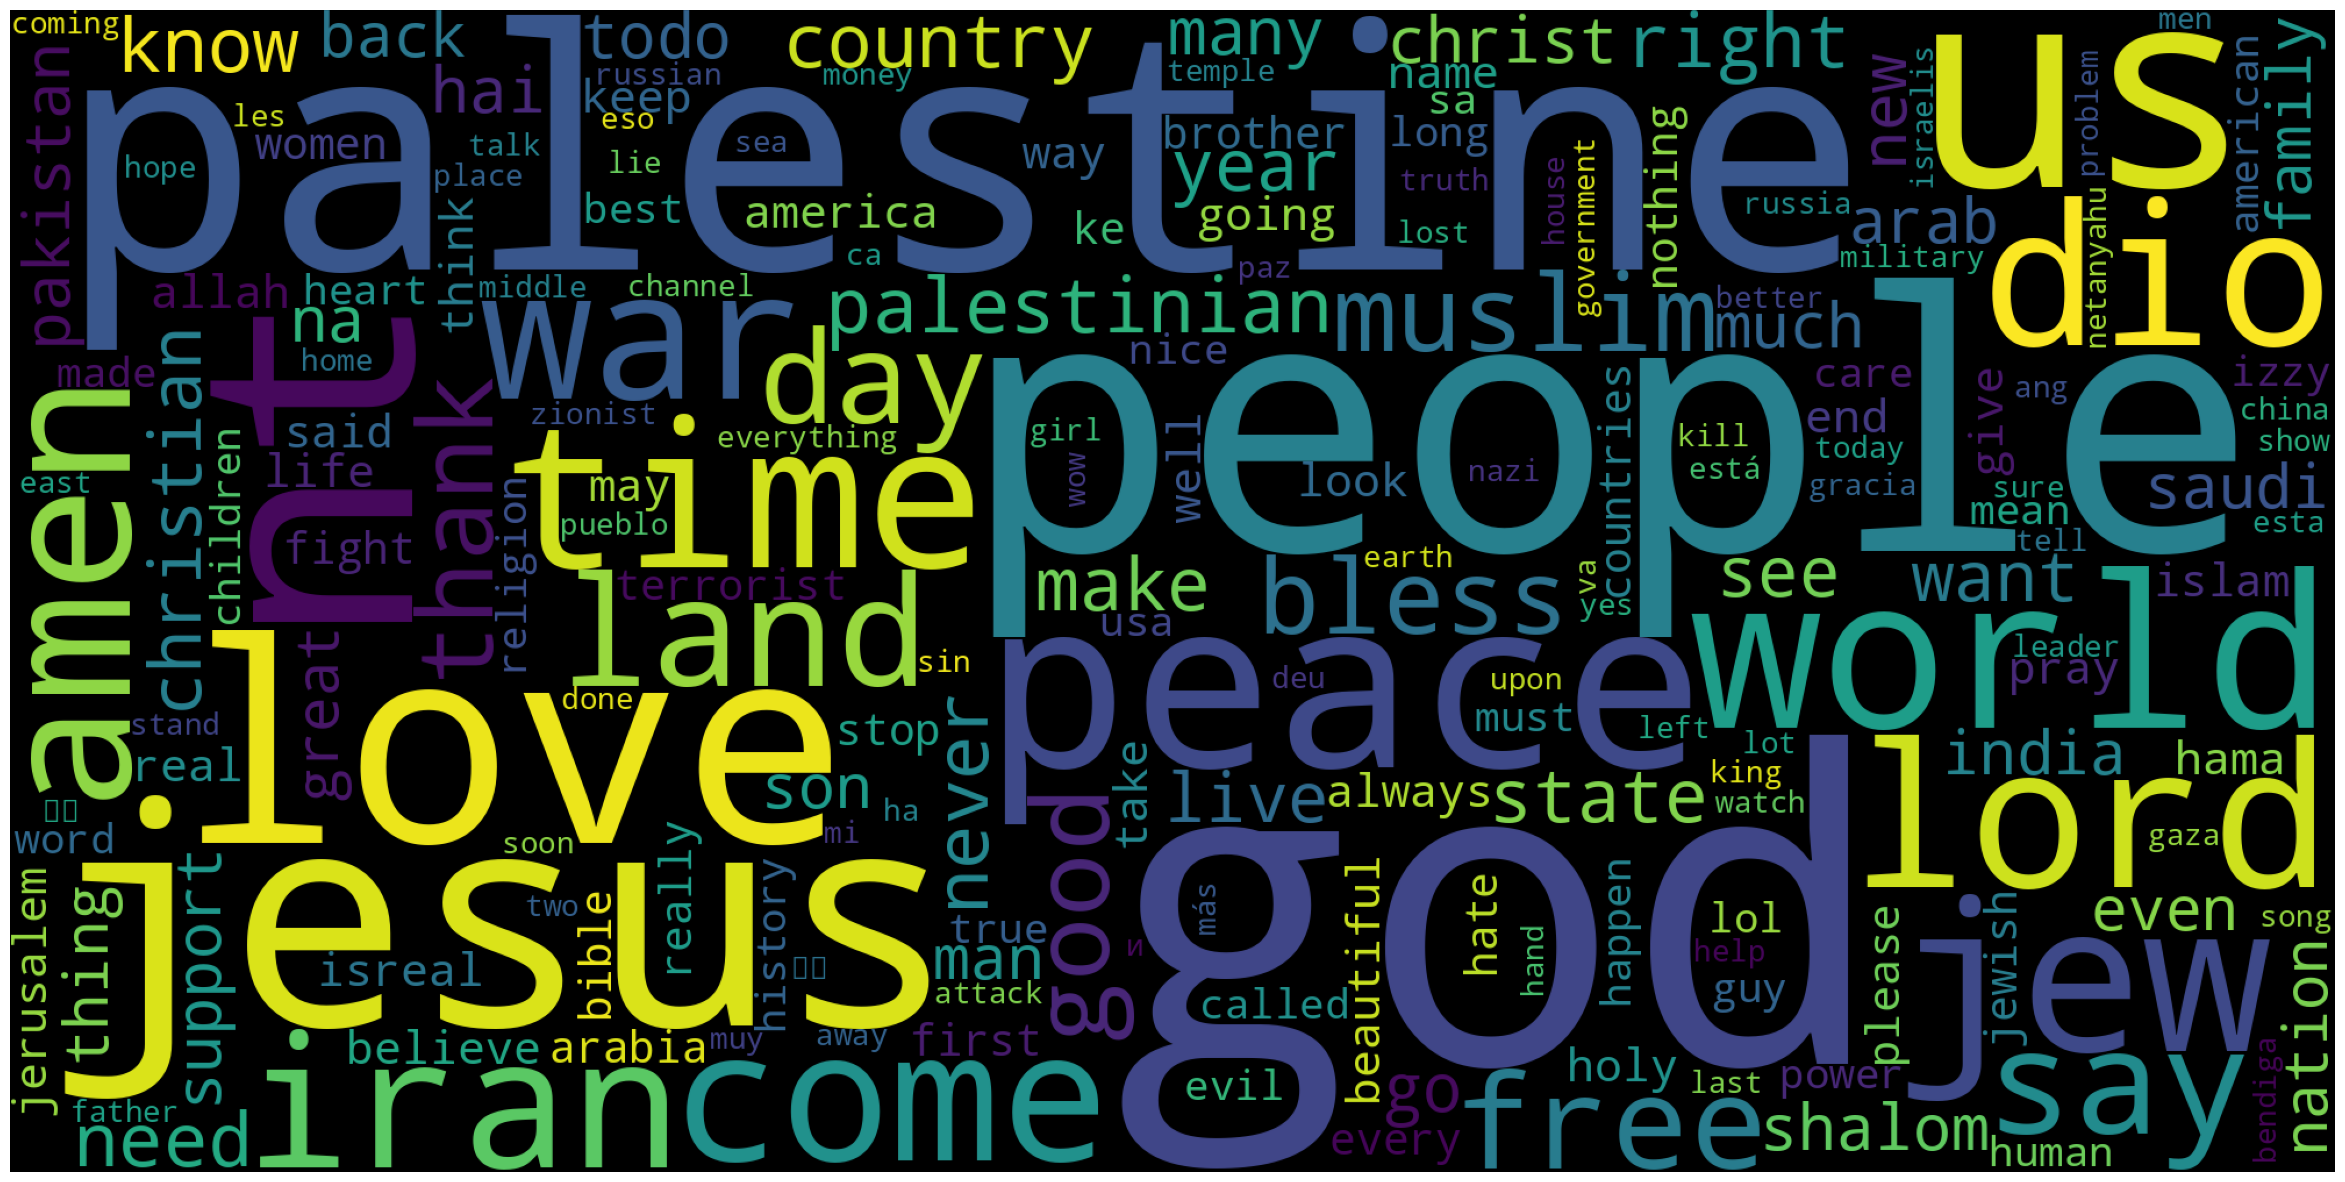

In [ ]:
## Wordcloud BEFORE attack ##
wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black',
                      colormap='viridis', collocations=False).generate(" ".join(words_before_filtered))
plot_cloud(wordcloud)

Now, a wordcloud from the comments *after* the attack.

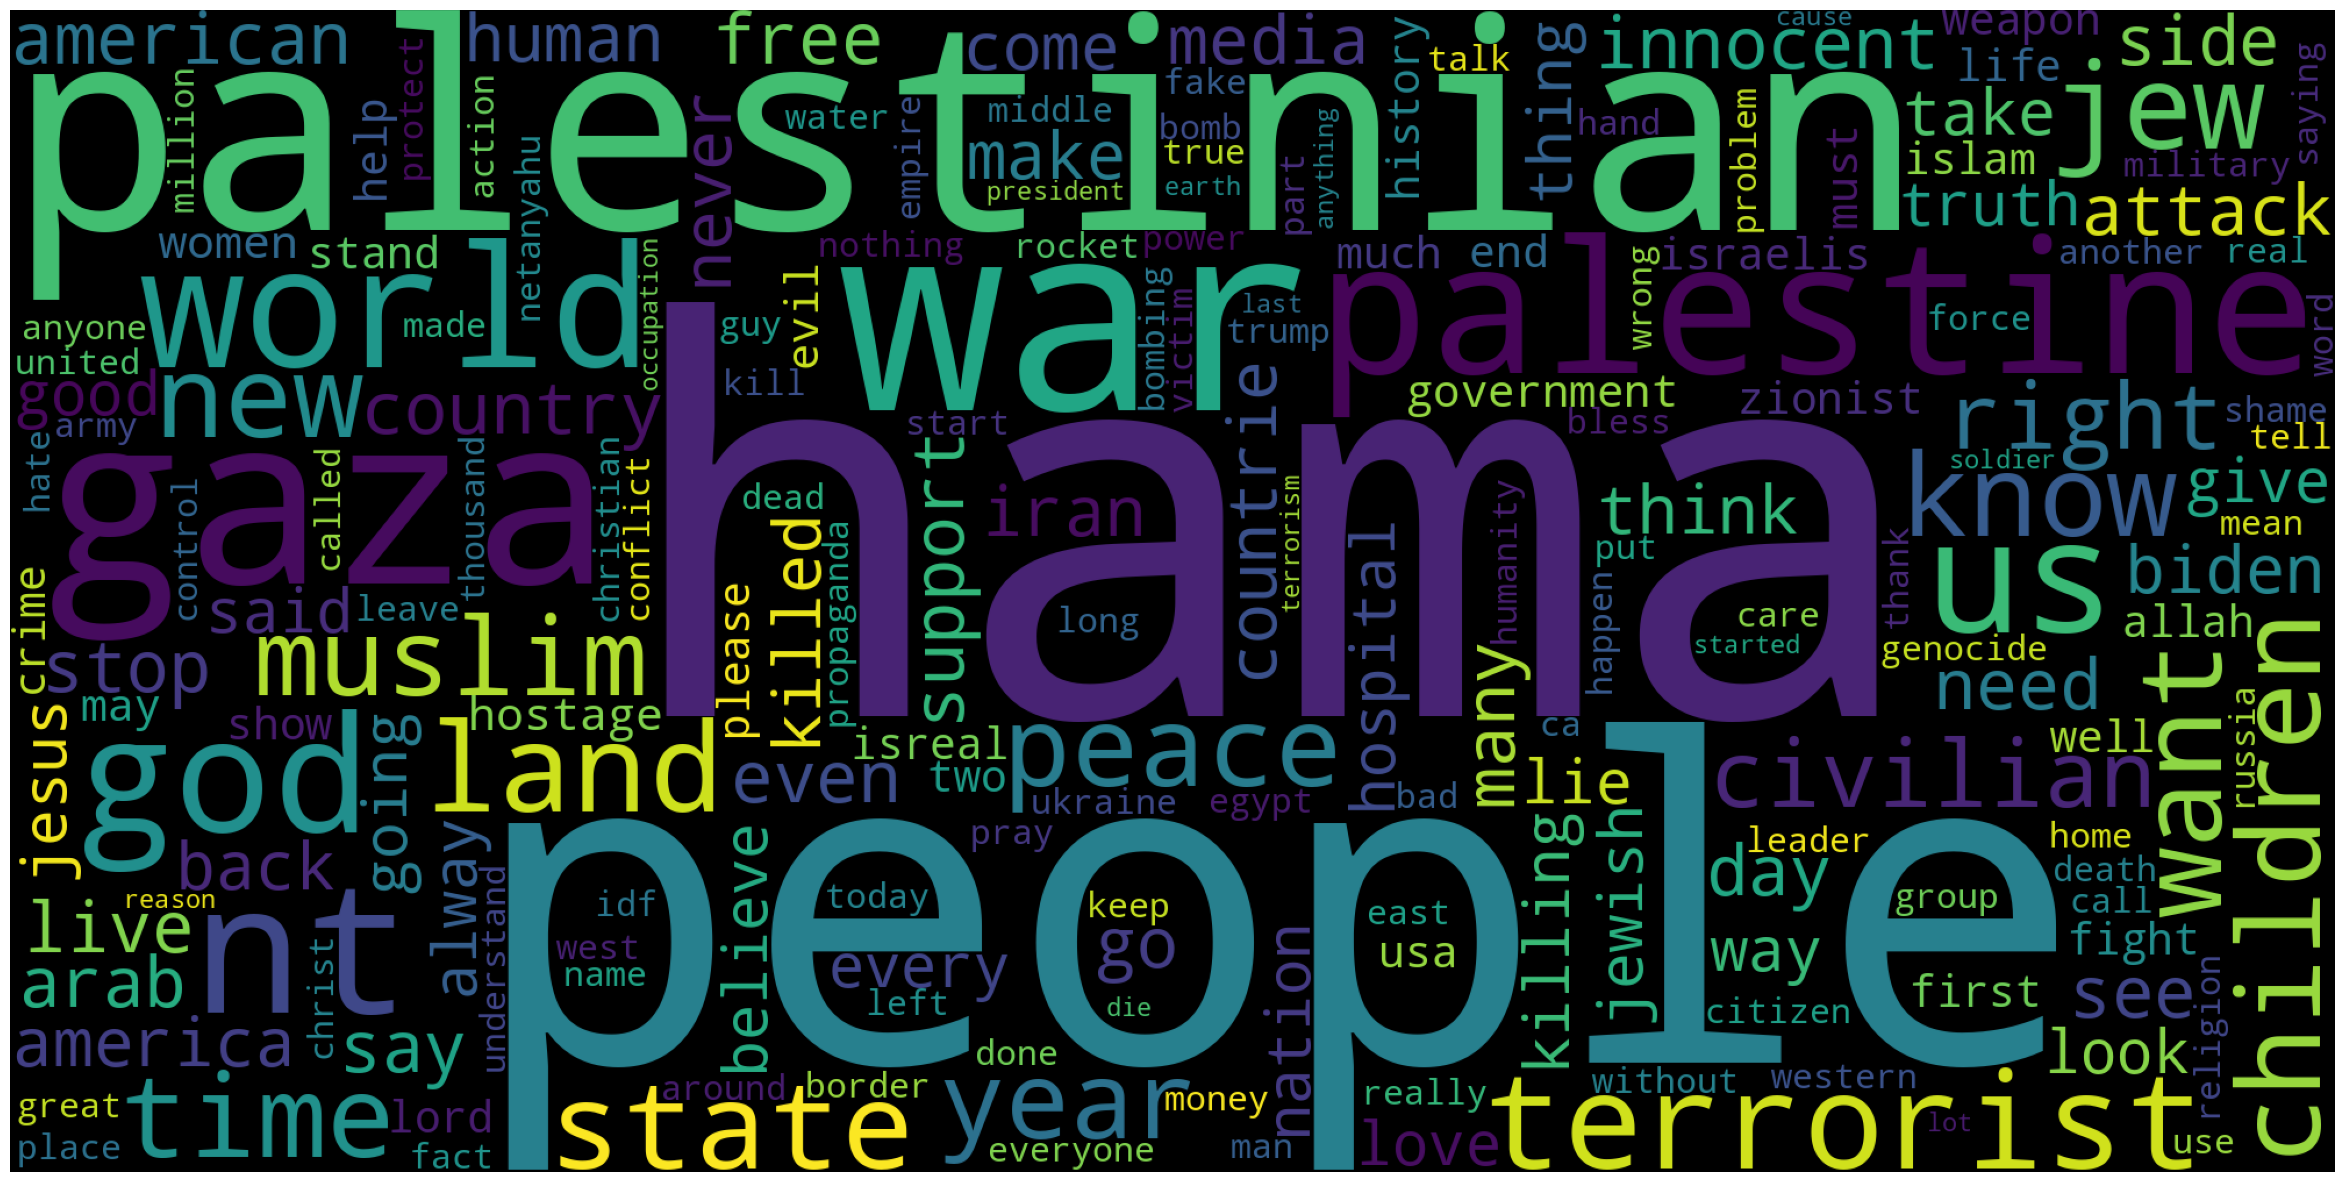

In [ ]:
## Wordcloud AFTER event ##
wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black',
                      colormap='viridis', collocations=False).generate(" ".join(words_after_filtered))
plot_cloud(wordcloud)

We can find a lot of interesting cues in the wordclouds:

- Prevalence of Specific Words: In both word clouds, terms related to the Israel-Palestine conflict are prevalent, such as "Palestine," "Gaza," and "Hamas." This suggests that discussions around this topic were consistent both before and after the incident.

- Shift in Emotion and Sentiment: After the terrorist attack, terms like "terrorist," "attack," "kill," and "war" seem to be more pronounced, indicating a potential shift in the tone of discussions, with an increase in negative sentiments and emotions. (We will carry out a sentiment analysis after this, to obtain some quantitave measures).

- Religious Undertones: Words like "God," "Jesus," "Muslim," and "Jew" are visible in both word clouds. This suggests that the discourse around the topic may often intertwine with religious discussions or sentiments.

- Global Perspective: There are mentions of other countries and regions, such as "USA," "Russia," "Iran," and "world," indicating that people are discussing the Israel-Palestine issue in a broader geopolitical context.

- Concern for Civilians: Terms like "children," "civilian," and "innocent" are more visible after the terrorist attack, possibly reflecting concerns for non-combatants affected by the conflict.

- Concern about war and peace: The presence of words like "peace," "love," and "support" alongside terms like "fight," "conflict," and "war" indicates that the search word "Israel" is commonly associated with conflict and peace attempts.

## Quantitative Sentiment Analysis

Fortunately, there are available tools to measure sentiment in a text. We will use one from the popular NLTK library.

In [ ]:
# Now we will conduct sentiment analysis on the comments before and after the event.
# We will use nltk.sentiment.vader
# The function sentiment_scores() returns a dictionary with the polarity scores for each comment.
def sentiment_scores(text):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(text)
    return sentiment_dict

In [ ]:
sentiment_before = sentiment_scores(" ".join(words_before_filtered))
sentiment_after = sentiment_scores(" ".join(words_after_filtered))

The objects we just obtained above are dictionaries that contain information about the comments' sentiment. But it will be more intuitive if we visualize these results as a bar chart.

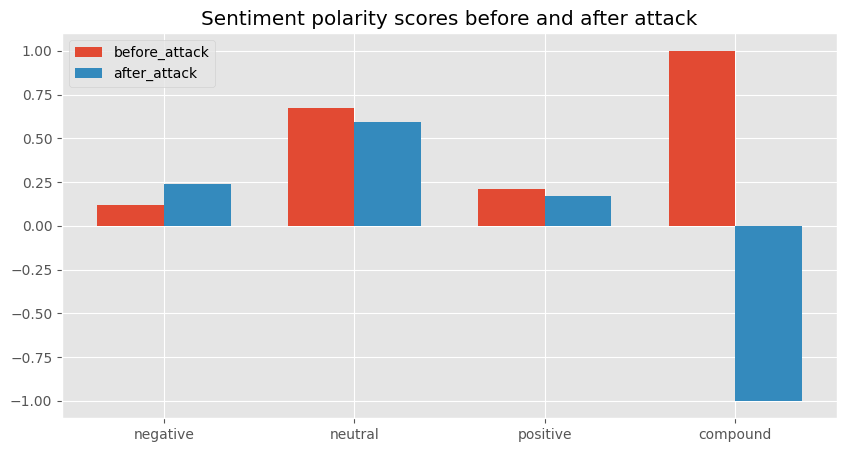

In [ ]:
# Bar chart of the polarity scores from comments before and after the attack
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
labels = ['negative', 'neutral', 'positive', 'compound']
x = np.arange(len(labels))
width = 0.35
plt.bar(x - width/2, list(sentiment_before.values()), width, label='before_attack')
plt.bar(x + width/2, list(sentiment_after.values()), width, label='after_attack')
plt.xticks(x, labels)
plt.legend()
plt.title("Sentiment polarity scores before and after attack")
plt.show()

The **negative sentiment score increases** significantly after the attack, suggesting that people were expressing more negative emotions or opinions in their comments regarding the event.

The **neutral sentiment score decreases** slightly after the attack, which may imply that people felt more strongly (either positive or negative) about the situation and were less inclined to be neutral.

We find also find **a decrease in the positive score** after the attack, indicating that there were fewer positive comments or feelings being expressed in relation to the event.

Most importantly, the compound score, which is an aggregate metric that combines the positive, negative, and neutral scores, became more negative after the attack. This signifies that, **on balance, the overall sentiment shifted to a more negative stance following the terrorist attack**.

# 5. CONCLUSION

We extracted YouTube video data, including comments, that contained the search term "Israel" in the video title. The dataset comprised 700 videos uploaded 2 weeks prior to the October 2023 Israel-Hamas confrontation, and another 700 videos that followed the Hamas attack. Our goal was to explore quantitatively and qualitatively the public's interest and sentiment with regards to the term "Israel".

As we might expect, the confrontation changed the public's level of interest in the topic, both in terms of quantity (e.g., almost 10 times as many video views after the attack compared to before) as well in terms of content (before the attack, "Israel" was associated with a varied mix of topics, for example related to religion and tourism; after the attack, "Israel" appeared almost exclusively associated with war and politics).

We conducted sentiment analysis pre and post event (the attack by Hamas), which revealed a very strong shift from "very positive" sentiment to "very negative" with respect to the keyword "Israel".

## Limitations

Can we conclude that the public (or, at least, the part of the public that is active on YouTube) used to like Israel, and now they dislike the country? We do not have enough evidence to make such a strong claim, for several reasons:
1. Striking news about any topic will overflood the media, eclipsing all previous views and comments on that topic just by the sheer amount of new information. If this new and abundant information is negative (which tends to be the case, unfortunately, with striking news), then the new average sentiment **associated** with this topic will also tend to be negative. But this negative association does not imply that people dislike the topic in question, it only implies that most of the times that people discussed the topic, there was something negative in the narrative. We might expect to encounter a similar sentiment shift if, for example, a huge earthquake devastated a certain country. Even if the corresponding average sentiment that we could extract from comments was positive before the earthquake, after such catastrophe the media would be deluged with sad and negative news, which would turn the new **associated** sentiment score into a negative one.
2. People tend more to express their opinions online about something if they have strong feelings, especially when these are negative. We can see this happening in Amazon reviews: even if a product is almost reaching the 5 stars, we might still find many reviews with extremely negative comments. Thus, a lot of negative comments does not imply that the whole population shares negative feelings; it could also be the case that a small part is very prolific at negative comments.
3. We do not know how well the active users of YouTube can represent the whole population. Even if active YouTube users tended now to dislike anything that has to do with Israel, we simply do not know if this could generalize to the whole population.   
4. This exploration is, of course, limited in many ways. For example, we gathered data from only one media platform, YouTube. Another limitation regards the sentiment analysis tool that we employed (based on NLTK's VADER). Namely, critics highlight its "bag of words" approach, which can miss the complexities of context and language nuances such as sarcasm or domain-specific jargon, potentially leading to inaccuracies in sentiment classification.

These limitations illustrate the need for good judgment when it comes to drawing conclusions from any analysis of the data. Knowing how to use our tools is not enough. Common sense is irreplaceable.